<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/biagiominio/Remote_sensing_2021/blob/main/R_code_land_cover.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/biagiominio/Remote_sensing_2021/blob/main/R_code_land_cover.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>




# Deforestation in Mato Grosso, Brazil

An inland state of central Brazil, deep in the Amazon interior, Mato Grosso was long isolated from the outside world. A railroad, followed by highways and airplanes, eventually connected this state with other regions in the twentieth century. By the early twenty-first century, modern technology had clearly reached Mato Grosso and produced widespread change.

The Thematic Mapper on NASA’s Landsat 5 satellite captured the top image of part of Mato Grosso on August 6, 1992. The Advanced Spaceborne Thermal Emission and Reflection Radiometer (ASTER) on NASA’s Terra satellite captured the bottom image of the same area on July 28, 2006. In both of these false-color images, red indicates vegetation, and the brighter the red, the denser the vegetation. The Rio Peixoto de Azevedo appears pale blue, nearly white, in 1992, perhaps a combination of reflective sediment or sunlight glinting off the water.

The most conspicuous difference between the images is the widespread forest clearing—visible as rectangles of gray-beige that had occurred by 2006. The most intense areas of clearing appear along roadways, such as road MT-419, which runs east to west north of the river. A 2006 study found that Brazil’s mechanized agriculture increased by more than 3.6 million hectares (8.9 million acres) between 2001 and 2004, growing more than 540,000 hectares (1.3 million acres) in Mato Grosso alone. Clearing for pasture was still the leading cause of deforestation at that time, but the contribution from large agricultural clearings, such as for soy plantations, was increasing.

<table>
  <tr>
     <td>Mato Grosso on August 6, 1992</td>
     <td>Mato Grosso on July 28, 2006</td>
  </tr>
  <tr>
    <td><img src="https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_l5_1992219_lrg.jpg" width=500</td>
    <td><img src="https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_ast_2006209_lrg.jpg" width=500</td>
  </tr>
</table>

<font size="2"> [*NASA images*](https://earthobservatory.nasa.gov/images/35891/deforestation-in-mato-grosso-brazil) *created by Jesse Allen, using Landsat data provided by the United States Geological Survey and ASTER data provided courtesy of NASA/GSFC/METI/ERSDAC/JAROS, and U.S./Japan ASTER Science Team. Caption by Michon Scott.*</font> 

In [1]:
mato_grosso_1992_url <- "https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_l5_1992219_lrg.jpg"
mato_grosso_2006_url <- "https://eoimages.gsfc.nasa.gov/images/imagerecords/35000/35891/matogrosso_ast_2006209_lrg.jpg"

The [download.file](https://www.rdocumentation.org/packages/utils/versions/3.6.2/topics/download.file) function can be used to download a file from the Internet. 
```
download.file(url, destfile)
```
In the function the `url` argument sets the resource to be downloaded and the `destfile` a character string with which the downloaded file is named.

In [2]:
download.file(mato_grosso_1992_url, "Mato_Grosso_1992.jpg")
download.file(mato_grosso_2006_url, "Mato_Grosso_2006.jpg")

## Install R packages
The [install.packages](https://www.rdocumentation.org/packages/utils/versions/3.6.2/topics/install.packages) function is used to download and install packages from CRAN-like repositories.
To install multiple packages at the same time, you define a vector that contains the names of the packages to be installed.

The [raster](https://www.rdocumentation.org/packages/raster/versions/3.4-10) package defines classes and methods for spatial raster data access and manipulation. 

[RStoolbox](https://www.rdocumentation.org/packages/RStoolbox/versions/0.2.6) is an package providing a wide range of tools for your every-day remote sensing processing needs. The available tool-set covers many aspects for remote sensing image processing and analysis such as calculating spectral indices, principal component transformation, unsupervised and supervised classification or fractional cover analyses.

The [ggplot2](https://www.rdocumentation.org/packages/ggplot2/versions/3.3.3) package is a system for declaratively creating graphics. 
It provides a more programmatic interface for specifying what variables to plot, how they are displayed, and general visual properties. 

While the [gridExtra](https://www.rdocumentation.org/packages/gridExtra/versions/2.3/topics/gridExtra-package) package provides a number of user-level functions to work with "grid" graphics, notably to arrange multiple grid-based plots on a page, and draw tables.

In [ ]:
packages <- c("raster", "RStoolbox", "ggplot2", "gridExtra")
install.packages(packages)

The [library](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/library) function is used to load previously installed packages.
Using the [lapply](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/lapply) function we simultaneously apply the `library()` function to all elements of the vector containing the packages.



In [ ]:
lapply(packages , library, character.only = TRUE)

## Reading spatial data
To read and view a multilevel object it is common to use the [brick](https://www.rdocumentation.org/packages/raster/versions/3.4-5/topics/brick) function (RasterBrick object). 

Explore the properties of the `mato_grosso_1992` and `mato_grosso_2006` object.



In [5]:
mato_grosso_1992 <- brick( "Mato_Grosso_1992.jpg")
mato_grosso_2006 <- brick( "Mato_Grosso_2006.jpg")

The brick object has three bands that correspond to the following portions of the electromagnetic spectrum:

$\mathsf{B1}$ = Near Infrared; 
$\mathsf{B2}$ = Red;
$\mathsf{B3}$ = Green;

Change the names of a raster object using the [names](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/names) function.


In [6]:
names(mato_grosso_1992) <- c("nir", "red", "green")
names(mato_grosso_2006) <- c("nir", "red", "green")
mato_grosso_1992

class      : RasterBrick 
dimensions : 1500, 1200, 1800000, 3  (nrow, ncol, ncell, nlayers)
resolution : 1, 1  (x, y)
extent     : 0, 1200, 0, 1500  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : Mato_Grosso_1992.jpg 
names      : nir, red, green 
min values :   0,   0,     0 
max values : 255, 255,   255 


The two images have a different extension and this could be a problem when comparing pixels or intersections. 

Let's see how to make the extension of the two images equal.

In [7]:
mato_grosso_2006@extent <- mato_grosso_1992@extent

Now the `mato_grosso_1992` image has the same extension as the `mato_grosso_2006` object, but has a different resolution and dimension.

To work around this problem, reduce the resolution of the `mato_grosso_2006` image by enlarging the pixels until they are the same size as the `mato_grosso_1992` object.
To create a new RasterBrick object with a lower resolution use the [aggregate](https://www.rdocumentation.org/packages/raster/versions/3.4-10/topics/aggregate) function of the `raster` package.

In [8]:
mato_grosso_2006.res <- aggregate(mato_grosso_2006, fun=mean, fact=2)
mato_grosso_2006.res

class      : RasterBrick 
dimensions : 1500, 1200, 1800000, 3  (nrow, ncol, ncell, nlayers)
resolution : 1, 1  (x, y)
extent     : 0, 1200, 0, 1500  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : nir, red, green 
min values :   0,   0,     0 
max values : 255, 255,   255 


## Visualization of spatial data
Several generic functions have been implemented for "raster" objects to create maps and other plot types. For example, use [plot](https://www.rdocumentation.org/packages/raster/versions/3.4-5/topics/plot) function to create a map of a raster object.
In addition, individual bands can be combined into a single image by assigning individual layers or bands to one of the three color channels (red, green and blue). 
The [plotRGB](https://www.rdocumentation.org/packages/raster/versions/3.4-5/topics/plotRGB) function can be used to make "true (or false) color images" from multi-band satellite images.

Use the [par](https://www.rdocumentation.org/packages/graphics/versions/3.6.2/topics/par) function to compare the images of Mato Grosso over the two different years.
Export the image using the [pdf](https://www.rdocumentation.org/packages/grDevices/versions/3.6.2/topics/pdf) function to enlarge it better and view the results.

N.B. always use the `dev.off()` function to manage the correct closing and loading of the graphics device.


In [ ]:
par(mfrow=c(1,2))
plotRGB(mato_grosso_1992, r=1, g=2, b=3, stretch="lin")
plotRGB(mato_grosso_2006.res, r=1, g=2, b=3, stretch="lin")

Use the [ggRGB](https://www.rdocumentation.org/packages/RStoolbox/versions/0.2.6/topics/ggRGB) function of the `ggplot2` package to improve the aesthetics of RGB plots.
With [grid.arrange](https://www.rdocumentation.org/packages/pdp/versions/0.7.0/topics/grid.arrange) one can reproduce the behaviour of the base functions `par(mfrow=c(r,c))` specifying either the number of rows or columns.

In [ ]:
pdf(file = "/content/compare_mato_grosso.pdf")
p1 <- ggRGB(mato_grosso_1992, r=1, g=2, b=3, stretch="lin")
p2 <- ggRGB(mato_grosso_2006.res, r=1, g=2, b=3, stretch="lin")
grid.arrange(p1, p2, nrow=1)

## Image Classification
The classification of remotely sensed images consists in associating each pixel of the image with a specific class or category (e.g. grassland, forest, water, soil, etc.).
Identification occurs through a process in which the degree of spectral similarity or association is high between pixels of the same category and low between pixels of distinct categories.

>It uses unsupervised learning methods to classify the two images of Mato Grosso in Brazil. Define a number of classes k to estimate the forest area lost from 1992 to 2006 or changes in land cover.

[K-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering is one of the simplest and popular unsupervised learning algorithms.
Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labeled, outcomes.

The `RStoolbox` package provides the [unsuperClass](https://www.rdocumentation.org/packages/RStoolbox/versions/0.2.6/topics/unsuperClass) function which allows you to apply the k-means algorithm to any Raster Object.

Furthermore, by setting the same seed with the [set.seed](https://www.rdocumentation.org/packages/simEd/versions/2.0.0/topics/set.seed) function (a random number generator) we always select the same initial pixels during the construction phase of the n-clusters in order to always show the same output.


In [38]:
set.seed(1234)
mato_grosso_1992.class <- RStoolbox::unsuperClass(mato_grosso_1992, nClasses=3)

Use function [colorRampPalette](https://www.rdocumentation.org/packages/dichromat/versions/1.1/topics/colorRampPalette) to create a continuous color scale divided into n-levels.


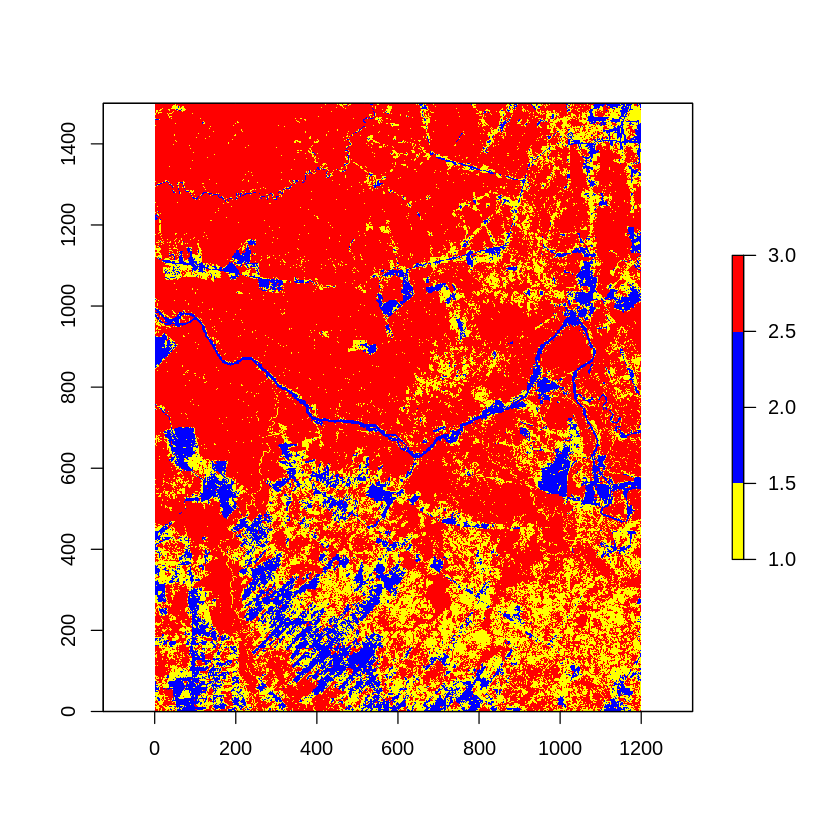

In [39]:
cl <- colorRampPalette(c('yellow','blue','red'))(3)
plot(mato_grosso_1992.class$map, col=cl)

The spatial patterns identified represent the main land cover classes:
* yellow indicates agricultural areas (cluster 1);
* and finally blue indicates waterways and wetlands cultivated with rice (cluster 2);
* red indicates forest (cluster 3).

Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known or labeled results. Therefore the content of each class should be validated in the field or compared with other data demonstrating belonging to the chosen land cover type. This step is very important and is useful for defining the accuracy of the classification model used.

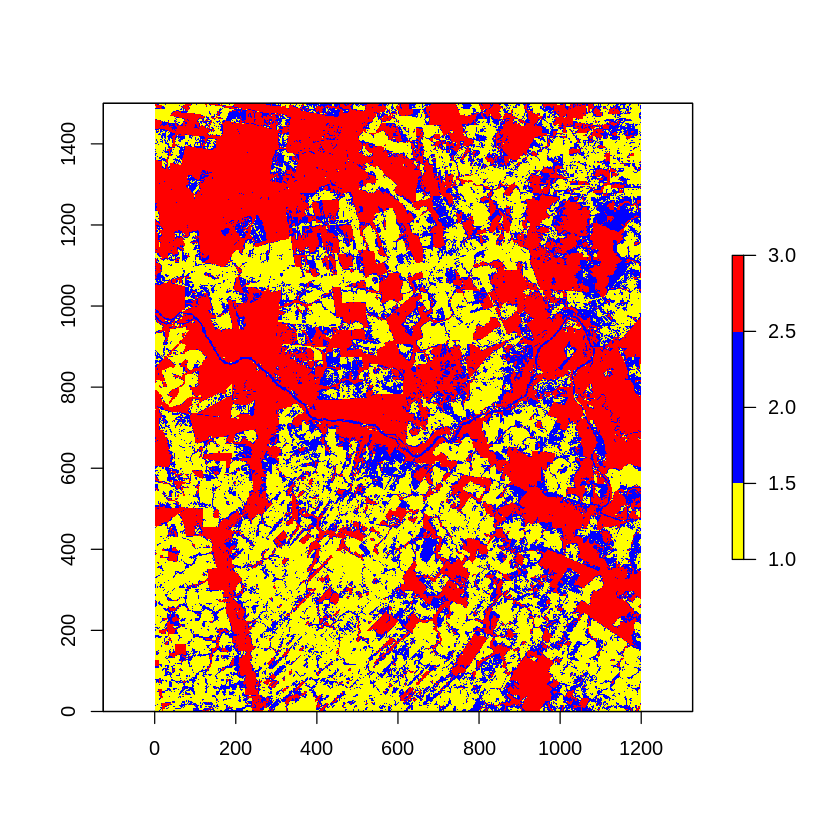

In [106]:
set.seed(23489)
mato_grosso_2006.res.class <- RStoolbox::unsuperClass(mato_grosso_2006.res, nClasses=3)
cl2 <- colorRampPalette(c('yellow','blue','red'))(3)
plot(mato_grosso_2006.res.class$map, col=cl2)

Also in this case the application of the same scheme seen previously facilitates the visual comparison.




## How much forest area has been lost?
Raster images are made up of pixels whose number and extent are known to us. Calculate the pixel frequency for each type of land cover or area knowing that each pixel has an extension of 30 m.

In statistics the frequency (or absolute frequency) of an event $i$ is the number $n_{i}$ of times the observation occurred/recorded in an experiment or study. Generate a frequency table using the [freq](https://www.rdocumentation.org/packages/questionr/versions/0.7.4/topics/freq) function.

In [ ]:
absolute_frequency_1992 <- freq(mato_grosso_1992.class$map) 
absolute_frequency_1992

Now calculate the relative frequency (or empirical probability) by dividing the number of counts or the absolute frequency by the total number of events:

$$f_{i}={\frac{n_{i}}{N}}={\frac{n_{i}}{\sum_{j}n_{j}}}$$

It also renames the three clusters by assigning the respective land cover to each of them.

Use the [data.frame](https://www.rdocumentation.org/packages/base/versions/3.6.2/topics/data.frame) function to create a data frame, a matrix-like structure whose columns may be of differing types (numeric, logical, factor and character and so on).

In [119]:
total_pixel_1992 <- sum(absolute_frequency_1992[,2]) 
relative_frequency_1992 <- absolute_frequency_1992[,2]/total_pixel_1992
labels <- c("Agriculture", "Wetlands", "Forest")
data_freq_1992 <- data.frame(cover = labels, count = relative_frequency_1992)
data_freq_1992

cover,count
<chr>,<dbl>
Agriculture,0.2165933
Wetlands,0.1110228
Forest,0.6723839


In 1992 the Mato Grosso area was mainly covered by woods with a coverage of about 63%. Only 22% was used for agriculture.

Apply the same procedure to the 2006 image.

In [ ]:
absolute_frequency_2006 <- freq(mato_grosso_2006.res.class$map) 
absolute_frequency_2006

In [118]:
total_pixel_2006 <- sum(absolute_frequency_2006[,2]) 
relative_frequency_2006 <- absolute_frequency_2006[,2]/total_pixel_2006
labels <- c("Agriculture", "Wetlands", "Forest")
data_freq_2006 <- data.frame(cover = labels, count = relative_frequency_2006)
data_freq_2006

cover,count
<chr>,<dbl>
Agriculture,0.3897956
Wetlands,0.2228594
Forest,0.3873450


In 2006 the frequencies changed in favor of the agricultural class with a coverage of 39%. Consider that the class called `"Wetlands"` includes both areas cultivated with rice and waterways. While the forest area has shrunk by a third.

In [154]:
merge_freq <- cbind.data.frame(cover=labels, 
                               freq_1992=data_freq_1992$count, 
                               freq_2006=data_freq_2006$count)
merge_freq 

cover,freq_1992,freq_2006
<chr>,<dbl>,<dbl>
Agriculture,0.2165933,0.3897956
Wetlands,0.1110228,0.2228594
Forest,0.6723839,0.3873450


In [164]:
pdf(file = "/content/compare_hist.pdf")
p_1992 <- ggplot(merge_freq, aes(x=cover, y=freq_1992, color=cover)) + geom_bar(stat="identity", fill="white") + ylim(0,0.68)
p_2006 <- ggplot(merge_freq, aes(x=cover, y=freq_2006, color=cover)) + geom_bar(stat="identity", fill="white") + ylim(0,0.68)
grid.arrange(p_1992, p_2006, nrow=1)
dev.off()

png 
  2